In [447]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import KDTree
from numpy.linalg import svd
from scipy.optimize import minimize

## 问题描述
在一个二维场景中，模拟机器人在不同位置扫描得到的激光束，然后根据两次扫描的激光束数据，计算机器人的位姿变换。

### 数据准备

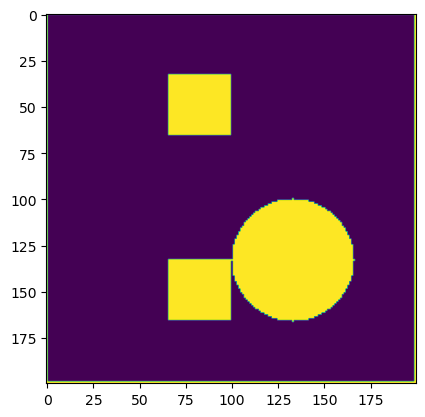

In [448]:
# 生成一个室内场景
def generate_scene(size):
    # 生成一个二维场景，0表示空，255表示墙壁
    scene = np.zeros((size, size), dtype=np.uint8)
    scene[0, :] = 255
    scene[-1, :] = 255
    scene[:, 0] = 255
    scene[:, -1] = 255
    scene[int(size/6):int(size/3), int(size/3):int(size/2)] = 255
    scene[int(size/3*2):int(size/6*5), int(size/3):int(size/2)] = 255
    # 画个圆
    cv2.circle(scene, (int(size/1.5), int(size/1.5)), int(size/6), 255, -1)
    return scene
scene = generate_scene(200)
plt.imshow(scene)

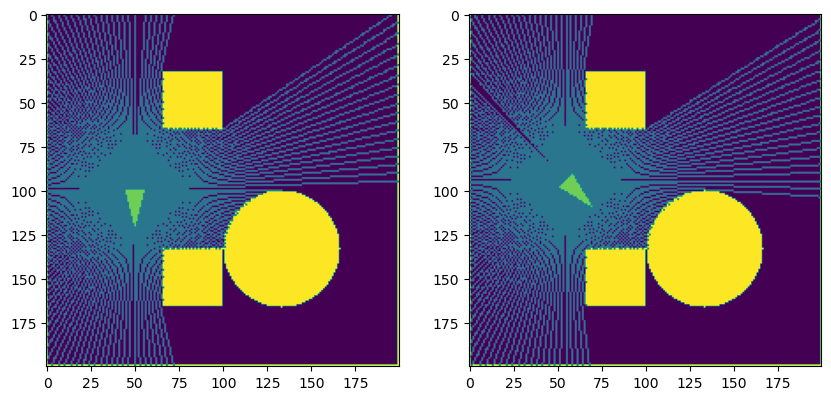

In [449]:
# 激光雷达参数
lidar_max_range = 10
lidar_min_range = 0.1
lidar_angle_resolution = np.pi / 100
lidar_angle_min = -np.pi
lidar_angle_max = np.pi
lidar_angle_num = int((lidar_angle_max - lidar_angle_min) / lidar_angle_resolution)
# 通过机器人位置和角度生成激光雷达数据
def generate_lidar_data(scene, robot_x, robot_y, robot_angle):
    # 扫描示意图
    scan_image = scene.copy()
    # 激光雷达数据
    lidar_data = np.zeros(lidar_angle_num, dtype=np.float32)
    # 生成激光雷达数据
    for i in range(lidar_angle_num):
        angle = robot_angle + lidar_angle_min + i * lidar_angle_resolution
        x = robot_x
        y = robot_y 
        while True:
            x += np.cos(angle)
            y += np.sin(angle)
            scan_image[int(x), int(y)] = 100
            if x < 0 or x >= scene.shape[0] or y < 0 or y >= scene.shape[1]:
                break
            if scene[int(x), int(y)] == 255:
                break
        lidar_data[i] = np.sqrt((x - robot_x) ** 2 + (y - robot_y) ** 2)
    # 三角绘制机器人位置（小角为朝向）
    robot_triangle = np.array([
        [robot_y + np.sin(robot_angle) * 20, robot_x + np.cos(robot_angle) * 20],
        [robot_y + np.sin(robot_angle + np.pi / 2) * 5, robot_x + np.cos(robot_angle + np.pi / 2) * 5],
        [robot_y + np.sin(robot_angle - np.pi / 2) * 5, robot_x + np.cos(robot_angle - np.pi / 2) * 5]
    ], dtype=np.int32)
    cv2.fillPoly(scan_image, [robot_triangle], 200)
    return lidar_data,scan_image
# 位姿1下的激光雷达数据
lidar_data_1, scan_image_1 = generate_lidar_data(scene, 100, 50, 0)
# 位姿2下的激光雷达数据
lidar_data_2, scan_image_2 = generate_lidar_data(scene, 95, 55, np.pi / 4)
# 可视化激光雷达数据
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(scan_image_1)
plt.subplot(122)
plt.imshow(scan_image_2)

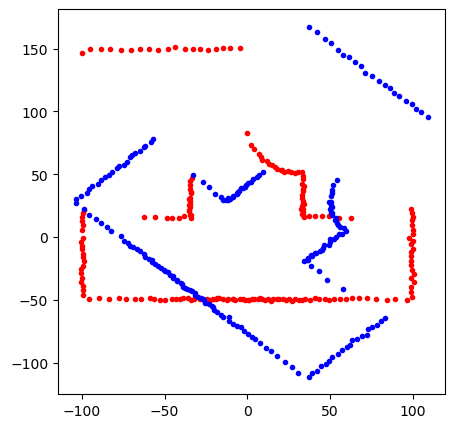

In [450]:
# 将range还原成坐标并加入一点噪声
lidar_coords_1 = np.zeros((lidar_angle_num, 2), dtype=np.float32)
lidar_coords_2 = np.zeros((lidar_angle_num, 2), dtype=np.float32)
for i in range(lidar_angle_num):
    angle = lidar_angle_min + i * lidar_angle_resolution
    lidar_coords_1[i, 0] = np.cos(angle) * lidar_data_1[i]+np.random.normal(0,0.5)
    lidar_coords_1[i, 1] = np.sin(angle) * lidar_data_1[i]+np.random.normal(0,0.5)
    lidar_coords_2[i, 0] = np.cos(angle) * lidar_data_2[i]+np.random.normal(0,0.5)
    lidar_coords_2[i, 1] = np.sin(angle) * lidar_data_2[i]+np.random.normal(0,0.5)
# 在一张图上用不同颜色绘制两个机器人的激光雷达数据
plt.figure(figsize=(5, 5))
plt.plot(lidar_coords_1[:, 0], lidar_coords_1[:, 1], 'r.')
plt.plot(lidar_coords_2[:, 0], lidar_coords_2[:, 1], 'b.')

### 正态分布变换 NDT(Normal Distributions Transform)

1. 定义栅格数据结构

In [451]:
# 定义栅格数据结构
class Grid:
    def __init__(self):
        self.points = []
        self.mean = 0
        self.cov_inv = np.zeros((2, 2), dtype=np.float32)
    # 添加一个点
    def add_point(self, point):
        self.points.append(point)
    # 计算均值和协方差
    def compute_mean_cov(self):
        self.mean = np.mean(self.points, axis=0)
        # 去中心化
        cov = np.cov(np.transpose(self.points))
        self.cov_inv = np.linalg.inv(cov)
    # 根据位置计算分数
    def compute_score(self, x, y):
        score = np.exp(-0.1 * np.dot(np.dot(np.array([x, y]) - self.mean, self.cov_inv), np.transpose(np.array([x, y]) - self.mean)))
        return score

2.将上一帧激光束数据转换为栅格数据

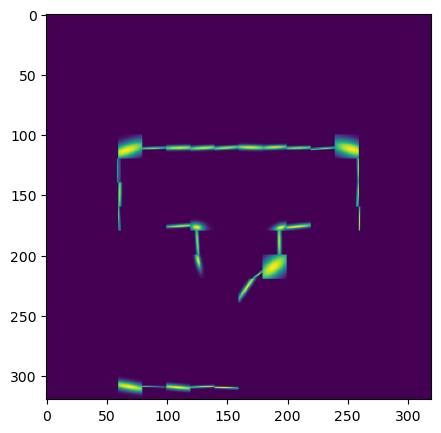

In [452]:
grid_resolution = 20
grid_min_x = -160
grid_max_x = 160
grid_min_y = -160
grid_max_y = 160
# 计算栅格的数量（向上取整）
grid_size_x = int(np.ceil((grid_max_x - grid_min_x) / grid_resolution))
grid_size_y = int(np.ceil((grid_max_y - grid_min_y) / grid_resolution))
# 创建一个栅格的二维数组
grids = np.empty((grid_size_x, grid_size_y), dtype=object)
# 将每个点分配到栅格中
for i in range(lidar_angle_num):
    x = int((lidar_coords_1[i, 0] - grid_min_x) / grid_resolution)
    y = int((lidar_coords_1[i, 1] - grid_min_y) / grid_resolution)
    if grids[x, y] is None:
        grids[x, y] = Grid()
    grids[x, y].add_point(lidar_coords_1[i])
# 计算每个栅格的均值和协方差
for i in range(grid_size_x):
    for j in range(grid_size_y):
        if grids[i, j] is not None and len(grids[i, j].points) > 2:
            grids[i, j].compute_mean_cov()
# 可视化栅格（遍历整个空间，计算每个位置的分数）
grid_scores = np.zeros((grid_max_x - grid_min_x, grid_max_y - grid_min_y), dtype=np.float32)
for i in range(grid_min_x, grid_max_x):
    for j in range(grid_min_y, grid_max_y):
        x = int((i - grid_min_x) / grid_resolution)
        y = int((j - grid_min_y) / grid_resolution)
        if grids[x, y] is not None and len(grids[x, y].points) > 2:
            grid_scores[i - grid_min_x, j - grid_min_y] = grids[x, y].compute_score(i, j)
        else:
            grid_scores[i - grid_min_x, j - grid_min_y] = 0
# 转置一下，使得x轴表示x坐标，y轴表示y坐标
grid_scores = np.transpose(grid_scores)
# 用图像显示分数
plt.figure(figsize=(5, 5))
plt.imshow(grid_scores)

3. 定义优化目标函数，将当前帧激光束数据映射到栅格上并计算分数

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


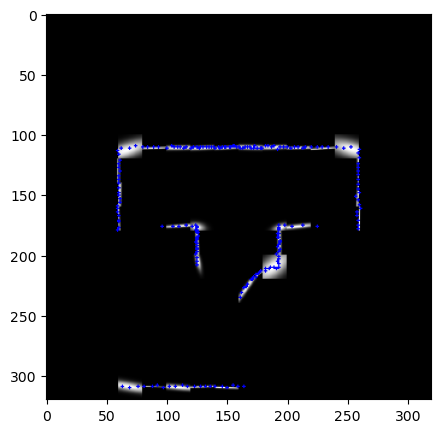

In [453]:
# 转换辅助函数
def transform_2d(x, y, delta_x, delta_y, delta_angle):
    R = np.array([
        [np.cos(delta_angle), -np.sin(delta_angle)],
        [np.sin(delta_angle), np.cos(delta_angle)]
    ])
    x_new = np.dot(R, np.array([x, y]))[0] + delta_x
    y_new = np.dot(R, np.array([x, y]))[1] + delta_y
    return x_new, y_new
# 将第二帧的激光雷达数据转换到第一帧构建的栅格中
def transform_map(lidar_coords, delta_x, delta_y, delta_angle):
    lidar_coords_new = np.zeros(lidar_coords.shape, dtype=np.float32)
    for i in range(lidar_angle_num):
        x_new, y_new = transform_2d(lidar_coords[i, 0], lidar_coords[i, 1], delta_x, delta_y, delta_angle)
        lidar_coords_new[i, 0] = y_new - grid_min_x
        lidar_coords_new[i, 1] = x_new - grid_min_y
    return lidar_coords_new
# 可视化第二帧激光雷达数据在第一帧栅格中的分布(真值)
map_coords_2 = transform_map(lidar_coords_2, -5, 5, np.pi / 4)
grid_scores_2 = grid_scores.copy()
# 将grid_scores转为rgb图像
grid_scores_2 = np.stack([grid_scores_2, grid_scores_2, grid_scores_2], axis=2)
# 将第二帧激光雷达数据的点绘制到rgb图像上
for point in map_coords_2:
    cv2.circle(grid_scores_2, (int(point[1]), int(point[0])), 1, (0, 0, 255), -1)
plt.figure(figsize=(5, 5))
plt.imshow(grid_scores_2)


In [454]:
# 定义分数计算函数，params代表[delta_x, delta_y, delta_angle]
def compute_score(params):
    delta_x = params[0]
    delta_y = params[1]
    delta_angle = params[2]
    # 将第二帧激光雷达数据转换到第一帧构建的栅格中
    map_coords_2 = transform_map(lidar_coords_2, delta_x, delta_y, delta_angle)
    # 计算分数
    score = 0
    for point in map_coords_2:
        x = int(point[0])
        y = int(point[1])
        if x >= 0 and x < grid_scores.shape[0] and y >= 0 and y < grid_scores.shape[1]:
            score += grid_scores[x, y]
    return -score
# 最好情况
compute_score([-5, 5, np.pi / 4])

-117.22897013535294

4. 使用优化算法优化目标函数

In [455]:
initial_guess = [-6 , 7 ,  np.pi / 4.5]
res = minimize(compute_score, initial_guess, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
res

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3780\2699656837.py:2: OptimizeWarning: Unknown solver options: xtol
  res = minimize(compute_score, initial_guess, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: -131.515508
         Iterations: 58
         Function evaluations: 132


 final_simplex: (array([[-4.66143665,  5.71917354,  0.78280782],
       [-4.6614561 ,  5.71914095,  0.78280798],
       [-4.66144219,  5.71908898,  0.78280778],
       [-4.66146412,  5.71910774,  0.78280817]]), array([-131.51550782, -131.51550782, -131.51550782, -131.51550782]))
           fun: -131.51550782099366
       message: 'Optimization terminated successfully.'
          nfev: 132
           nit: 58
        status: 0
       success: True
             x: array([-4.66143665,  5.71917354,  0.78280782])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


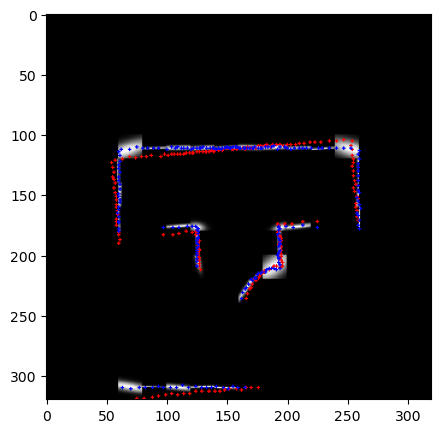

In [456]:
# 可视化结果
delta_x = res.x[0]
delta_y = res.x[1]
delta_angle = res.x[2]
map_coords_initial = transform_map(lidar_coords_2, initial_guess[0], initial_guess[1], initial_guess[2])
map_coords_final = transform_map(lidar_coords_2, delta_x, delta_y, delta_angle)
grid_scores_2 = grid_scores.copy()
# 将grid_scores转为rgb图像
grid_scores_2 = np.stack([grid_scores_2, grid_scores_2, grid_scores_2], axis=2)
# 将第二帧激光雷达数据的点绘制到rgb图像上
for point in map_coords_initial:
    # 初始猜测
    cv2.circle(grid_scores_2, (int(point[1]), int(point[0])), 1, (255, 0, 0), -1)
for point in map_coords_final:
    # ndt结果
    cv2.circle(grid_scores_2, (int(point[1]), int(point[0])), 1, (0, 0, 255), -1)
plt.figure(figsize=(5, 5))
plt.imshow(grid_scores_2)